In [1]:
# Set environment variable to avoid symbolic tracing issues
import os
os.environ['TIMM_FUSED_ATTN'] = '0'
import warnings
warnings.filterwarnings('ignore')
from torchvision import transforms
from datasets import load_dataset
from pytorch_grad_cam import run_dff_on_image, GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import cv2
import torch
from typing import List, Callable, Optional

# Import XAI methods
from baselines.GradCAM_v2 import PytorchCAM
from baselines.RISE import RISEBatch
from baselines.Attention import Attention_Map
from baselines.ViT_explanation_generator import LRP, Baselines
from pytorch_grad_cam import GradCAM, ScoreCAM

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from PIL import Image
from pathlib import Path


In [2]:
from transformers import (
    ViTImageProcessor, ViTForImageClassification,
    AutoImageProcessor, EfficientNetForImageClassification,
    ResNetForImageClassification, AutoModel
)
import models_vit as models
from util.datasets import TransformWrapper
import timm

#get model
def get_model(task,model,input_size,nb_classes):
    if 'ADCon' in task:
        id2label = {0: "control", 1: "ad"}
        label2id = {v: k for k, v in id2label.items()}
    else:
        id2label = {i: f"class_{i}" for i in range(nb_classes)}
        label2id = {v: k for k, v in id2label.items()}
    processor = None
    if 'RETFound_mae' in model:
        model = models.__dict__['RETFound_mae'](
        img_size=input_size,
        num_classes=nb_classes,
        drop_path_rate=0.2,
        global_pool=True,
    )
    elif 'vit-base-patch16-224' in model:
        # ViT-base-patch16-224 preprocessor
        model_ = 'google/vit-base-patch16-224'
        processor = TransformWrapper(ViTImageProcessor.from_pretrained(model_))
        model = ViTForImageClassification.from_pretrained(
            model_,
            image_size=input_size, #Not in tianhao code, default 224
            num_labels=nb_classes,
            hidden_dropout_prob=0.0, #Not in tianhao code, default 0.0
            attention_probs_dropout_prob=0.0, #Not in tianhao code, default 0.0
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True,
            attn_implementation="eager",      # ← key line
        )
        model.config.return_dict = True
        model.config.output_attentions = True
    elif 'timm_efficientnet-b4' in model:
        model = timm.create_model('efficientnet_b4', pretrained=True, num_classes=nb_classes)
        processor  = transforms.Compose([
            transforms.Resize((380,380)),
            transforms.ToTensor(),
            transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])
    elif 'ResNet-50' in model:
        model_name = 'microsoft/resnet-50'
        processor = TransformWrapper(AutoImageProcessor.from_pretrained(model_name))
        model = ResNetForImageClassification.from_pretrained(
            model_name,
            num_labels=nb_classes,
            id2label=id2label,
            label2id=label2id,
            ignore_mismatched_sizes=True
        )
        model.config.return_dict = True
        model.config.output_attentions = True

    return model, processor

In [3]:
# task and dataset
#Task_list = ['ADCon','DME']
Task_list = ['DME']
dataset_fname = 'sampled_labels01.csv'
dataset_dir = '/blue/ruogu.fang/tienyuchang/OCT_EDA'
img_p_fmt = "label_%d/%s" #label index and oct_img name

# model
Model_root = "/blue/ruogu.fang/tienyuchang/RETFound_MAE/output_dir"
Model_fname = "checkpoint-best.pth"
Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']
ADCon_finetuned = [
    "",
    "",
    "",
    "ad_control_detect_data-IRB2024v5_ADCON_DL_data-all-RETFound_mae-OCT-defaulteval---bal_sampler-/"
]
DME_finetuned = [
    "DME_binary_all_split-IRB2024_v5-all-microsoft/resnet-50-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-timm_efficientnet-b4-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-google/vit-base-patch16-224-in21k-OCT-bs16ep50lr5e-4optadamw-defaulteval-trsub0--/",
    "DME_binary_all_split-IRB2024_v5-all-RETFound_mae_natureOCT-OCT-bs16ep50lr5e-4optadamw-roc_auceval-trsub0--/"
]

In [ ]:
# Data loading and preprocessing functions
def load_sample_data(task, num_sample=-1):
    """Load sample images for a given task"""
    df = pd.read_csv(os.path.join(dataset_dir, "%s_sampled"%task, dataset_fname))
    task_df = df[df['label'].isin([0, 1])]  # Adjust based on actual DME labels
    # Sample random images
    if num_sample > 0:
        task_df = task_df.sample(n=num_sample, random_state=42).reset_index(drop=True)
    else:
        task_df = task_df.reset_index(drop=True)
    
    images = []
    labels = []
    filenames = []
    
    for _, row in task_df.iterrows():
        # Extract just the filename from oct_img
        filename = os.path.basename(row['OCT']) if isinstance(row['OCT'], str) else row['OCT']
        img_path = os.path.join(dataset_dir, "%s_sampled"%task, img_p_fmt % (row['label'], filename))
        if os.path.exists(img_path):
            try:
                img = Image.open(img_path).convert('RGB')
                images.append(img)
                labels.append(row['label'])
                # Store filename without extension for directory naming
                image_name = os.path.splitext(filename)[0]
                filenames.append(image_name)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
    
    return images, labels, filenames

def preprocess_image(image, processor=None, input_size=224, device=None, dtype=torch.float32):
    """
    将 PIL.Image -> [1,3,H,W] tensor（float32），自动适配：
      - timm/torchvision transforms：processor(image)
      - HuggingFace ImageProcessor：processor(image, return_tensors="pt") 或返回 dict
      - 最后回退到标准 ImageNet 预处理
    """
    assert isinstance(image, Image.Image), f"expect PIL.Image, got {type(image)}"
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")

    if processor is not None:
        # A) 先尝试“直接可调用”形式（多数 timm/torchvision transform）
        try:
            out = processor(image)
            if isinstance(out, torch.Tensor):
                x = out
                if x.ndim == 3:  # [C,H,W] -> [1,C,H,W]
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
            if isinstance(out, dict) and "pixel_values" in out:
                x = out["pixel_values"]
                if isinstance(x, np.ndarray):
                    x = torch.from_numpy(x)
                if x.ndim == 3:
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
        except TypeError:
            pass

        # B) 再尝试 HuggingFace 风格（不使用 images= 关键字）
        try:
            out = processor(image, return_tensors="pt")
            if isinstance(out, dict) and "pixel_values" in out:
                x = out["pixel_values"]  # [1,3,H,W]
                return x.to(device=device, dtype=dtype)
            if isinstance(out, torch.Tensor):
                x = out
                if x.ndim == 3:
                    x = x.unsqueeze(0)
                return x.to(device=device, dtype=dtype)
        except TypeError:
            pass

        # C) 某些实现仅接受列表
        for attempt in (lambda: processor([image], return_tensors="pt"),
                        lambda: processor([image])):
            try:
                out = attempt()
                if isinstance(out, dict) and "pixel_values" in out:
                    x = out["pixel_values"]
                    if isinstance(x, np.ndarray):
                        x = torch.from_numpy(x)
                    return x.to(device=device, dtype=dtype)
                if isinstance(out, torch.Tensor):
                    x = out
                    if x.ndim == 3:
                        x = x.unsqueeze(0)
                    return x.to(device=device, dtype=dtype)
            except TypeError:
                pass

    # D) 回退：标准 ImageNet 预处理
    fallback = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),  # [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    x = fallback(image)            # [3,H,W]
    x = x.unsqueeze(0)             # [1,3,H,W]
    return x.to(device=device, dtype=dtype)

#test dataset
dme_imgs, dme_labels, dme_img_names = load_sample_data('DME',3)
print(len(dme_imgs))
print(dme_imgs[0])
print(dme_labels[0])

3
<PIL.Image.Image image mode=RGB size=512x496 at 0x1494B53A5850>
0


In [5]:

# Load trained models function
def load_trained_model(task, model_name, input_size=224, nb_classes=2):
    """Load a trained model for a specific task"""
    model, processor = get_model(task, model_name, input_size, nb_classes)
    
    # Load model weights based on task and model
    if task == 'ADCon':
        model_paths = ADCon_finetuned
    elif task == 'DME':
        model_paths = DME_finetuned
    else:
        print(f"Unknown task: {task}")
        model.eval()
        return model, processor
    
    model_idx = Model_list.index(model_name)
    model_dir = model_paths[model_idx]
    model_path = os.path.join(Model_root, model_dir, Model_fname)
    
    # Load finetuned model if specified (following main_XAI_evaluation.py pattern)
    if model_path and model_path != '':
        if os.path.exists(model_path):
            try:
                # Load checkpoint
                if model_path.startswith('https'):
                    checkpoint = torch.hub.load_state_dict_from_url(
                        model_path, map_location='cpu', check_hash=True)
                else:
                    checkpoint = torch.load(model_path, map_location='cpu', weights_only=False)
                
                # Extract model state dict
                if 'model' in checkpoint:
                    checkpoint_model = checkpoint['model']
                else:
                    checkpoint_model = checkpoint
                
                # Load with strict=False to handle potential mismatches
                model.load_state_dict(checkpoint_model, strict=False)
                print(f"Resume checkpoint {model_path} for {model_name} on {task}")
                
            except Exception as e:
                print(f"Error loading model {model_name} for {task}: {e}")
                print("Using pretrained weights instead")
        else:
            print(f"Model path not found: {model_path}")
            print(f"Using pretrained weights for {model_name} on {task}")
    else:
        print(f"No checkpoint specified for {model_name} on {task}, using pretrained weights")
    
    model.eval()
    return model, processor

#test
'''
model_list = []
for model_name in Model_list:
    model, processor = load_trained_model('DME', model_name, 224)
    print(type(model))
    model_list.append(model)
'''

"\nmodel_list = []\nfor model_name in Model_list:\n    model, processor = load_trained_model('DME', model_name, 224)\n    print(type(model))\n    model_list.append(model)\n"

In [6]:
# XAI Methods Implementation
class XAIGenerator:
    def __init__(self, model, model_name, input_size=224):
        self.model = model
        self.model_name = model_name
        self.input_size = input_size
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        
        # Initialize XAI methods
        self.init_xai_methods()
    
    def get_model_specific_config(self):
        """Get model-specific configuration for XAI methods"""
        config = {
            'patch_size': 14,
            'gpu_batch': 1,
            'attention_layers': 12
        }
        
        # Model-specific configurations
        if 'resnet' in self.model_name.lower():
            config.update({
                'patch_size': 7,  # ResNet has different spatial resolution
                'gpu_batch': 1,  # ResNet can handle larger batches
            })
        elif 'efficientnet' in self.model_name.lower():
            config.update({
                'patch_size': 7,  # EfficientNet spatial resolution
                'gpu_batch': 1,
            })
        elif 'vit' in self.model_name.lower():
            config.update({
                'patch_size': 16,  # ViT patch size
                'gpu_batch': 1,
                'attention_layers': 12,  # Standard ViT-Base layers
            })
        elif 'retfound' in self.model_name.lower():
            config.update({
                'patch_size': 16,  # RETFound uses ViT architecture
                'gpu_batch': 1,
                'attention_layers': 12,
            })
        
        return config
    
    def init_xai_methods(self):
        """Initialize all XAI methods with model-specific configurations"""
        config = self.get_model_specific_config()
        # GradCAM with model-specific config
        self.gradcam = PytorchCAM(
            self.model, 
            self.model_name, 
            self.input_size, 
            patch_size=config['patch_size'],
            method=GradCAM
        )
        print(f"✓ GradCAM initialized for {self.model_name} (patch_size: {config['patch_size']})")
        
        # ScoreCAM with model-specific config
        self.scorecam = PytorchCAM(
            self.model, 
            self.model_name, 
            self.input_size, 
            patch_size=config['patch_size'],
            method=ScoreCAM
        )
        print(f"✓ ScoreCAM initialized for {self.model_name} (patch_size: {config['patch_size']})")
        
        # RISE with model-specific batch size
        # Reduce batch for memory-heavy models
        rise_batch = config['gpu_batch']
        if 'retfound' in self.model_name.lower():
            rise_batch = min(rise_batch, 16)
        self.rise = RISEBatch(
            self.model, 
            input_size=(self.input_size, self.input_size), 
            gpu_batch=rise_batch,
            N=50
        )
        print(f"✓ RISE initialized for {self.model_name} (gpu_batch: {rise_batch})")
        
        try:
            # Attention Maps (only for ViT-based models)
            if 'vit' in self.model_name.lower() or 'retfound' in self.model_name.lower():
                self.attention = Attention_Map(
                    self.model, 
                    self.model_name, 
                    self.input_size, 
                    N=config['attention_layers'],
                    use_rollout=True,
                    print_layers=False  # Disable layer printing to avoid issues
                )
                print(f"✓ Attention initialized for {self.model_name} (layers: {config['attention_layers']})")
            else:
                self.attention = None
                print(f"⚠ Attention skipped for {self.model_name} (not a transformer model)")
        except Exception as e:
            print(f"✗ Failed to initialize Attention for {self.model_name}: {e}")
            print(f"  Note: This may be due to symbolic tracing issues with the model architecture")
            
            # Try alternative attention extraction for RETFound
            if 'retfound' in self.model_name.lower():
                try:
                    print(f"  🔄 Trying alternative attention extraction for RETFound...")
                    self.attention = self._create_simple_attention_extractor()
                    print(f"✓ Alternative attention method initialized for {self.model_name}")
                except Exception as e2:
                    print(f"✗ Alternative attention method also failed: {e2}")
                    self.attention = None
            else:
                self.attention = None
        
        # LRP (requires special model implementation)
        self.lrp = None  # Will implement if model supports it
    
    def generate_gradcam(self, image_tensor, target_class=None):
        """Generate GradCAM heatmap"""
        if self.gradcam is None:
            return None
        image_tensor = image_tensor.to(self.device)
        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        targets = [ClassifierOutputTarget(target_class)]
        heatmap = self.gradcam(image_tensor, targets)
        return heatmap[0] if len(heatmap) > 0 else None
    
    def generate_scorecam(self, image_tensor, target_class=None):
        """Generate ScoreCAM heatmap"""
        if self.scorecam is None:
            return None
        image_tensor = image_tensor.to(self.device)
        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        targets = [ClassifierOutputTarget(target_class)]
        heatmap = self.scorecam(image_tensor, targets)
        return heatmap[0] if len(heatmap) > 0 else None
    
    def generate_rise(self, image_tensor, target_class=None):
        """Generate RISE heatmap"""
        if self.rise is None:
            return None
        image_tensor = image_tensor.to(self.device)

        if target_class is None:
            # Get predicted class
            with torch.no_grad():
                outputs = self.model(image_tensor)
                target_class = outputs.argmax(dim=1).item()

        heatmaps = self.rise(image_tensor)
        return heatmaps[0, target_class] if heatmaps is not None else None
    
    def generate_attention(self, image_tensor):
        """Generate Attention heatmap"""
        if self.attention is None:
            return None
        image_tensor = image_tensor.to(self.device)
        attention_map = self.attention(image_tensor)
        return attention_map[0] if attention_map is not None else None
    
    def generate_all_heatmaps(self, image_tensor, target_class=None):
        """Generate all available heatmaps for an image"""
        heatmaps = {}
        
        # GradCAM
        gradcam_map = self.generate_gradcam(image_tensor, target_class)
        if gradcam_map is not None:
            heatmaps['GradCAM'] = gradcam_map
        
        # ScoreCAM
        scorecam_map = self.generate_scorecam(image_tensor, target_class)
        if scorecam_map is not None:
            heatmaps['ScoreCAM'] = scorecam_map
        
        # RISE
        '''
        rise_map = self.generate_rise(image_tensor, target_class)
        if rise_map is not None:
            heatmaps['RISE'] = rise_map
        '''
        
        # Attention
        attention_map = self.generate_attention(image_tensor)
        if attention_map is not None:
            heatmaps['Attention'] = attention_map
        
        return heatmaps
    
    def _create_simple_attention_extractor(self):
        """Create a simple attention extractor that doesn't use symbolic tracing"""
        class SimpleAttentionExtractor:
            def __init__(self, model, model_name, input_size):
                self.model = model
                self.model_name = model_name
                self.input_size = input_size
                self.attention_maps = []
                
                # Register hooks to capture attention weights
                self.hooks = []
                if hasattr(model, 'blocks'):
                    for i, block in enumerate(model.blocks):
                        if hasattr(block, 'attn'):
                            hook = block.attn.register_forward_hook(self._attention_hook)
                            self.hooks.append(hook)
            
            def _attention_hook(self, module, input, output):
                """Hook to capture attention weights"""
                # Try to get attention weights from different possible attributes
                if hasattr(module, 'attention_probs'):
                    self.attention_maps.append(module.attention_probs.detach())
                elif hasattr(module, 'attn_weights'):
                    self.attention_maps.append(module.attn_weights.detach())
                elif len(output) > 1 and isinstance(output[1], torch.Tensor):
                    # Some models return attention as second output
                    self.attention_maps.append(output[1].detach())
            
            def __call__(self, x):
                """Extract attention maps"""
                self.attention_maps = []
                
                # Forward pass to trigger hooks
                with torch.no_grad():
                    _ = self.model(x)
                
                if len(self.attention_maps) > 0:
                    try:
                        # Use the last attention layer
                        last_attention = self.attention_maps[-1]  # Shape: (B, num_heads, num_tokens, num_tokens)
                        
                        # Average over heads and extract CLS attention to patches
                        if len(last_attention.shape) == 4:  # (B, num_heads, num_tokens, num_tokens)
                            cls_attention = last_attention.mean(dim=1)[:, 0, 1:]  # (B, num_patches)
                        else:
                            # Fallback for different attention shapes
                            cls_attention = last_attention[:, 0, 1:] if last_attention.shape[1] > 1 else last_attention[:, 0]
                        
                        # Reshape to spatial dimensions
                        B = cls_attention.shape[0]
                        num_patches = cls_attention.shape[1]
                        patch_size = int(num_patches ** 0.5)
                        
                        if patch_size * patch_size == num_patches:
                            attention_maps = cls_attention.reshape(B, patch_size, patch_size)
                            
                            # Resize to input size
                            attention_maps_resized = torch.nn.functional.interpolate(
                                attention_maps.unsqueeze(1), 
                                size=(self.input_size, self.input_size), 
                                mode='bilinear', 
                                align_corners=False
                            ).squeeze(1)
                            
                            return attention_maps_resized.cpu().numpy()
                    except Exception as e:
                        print(f"Error processing attention maps: {e}")
                
                # Fallback: return zeros
                return np.zeros((x.shape[0], self.input_size, self.input_size))
            
            def cleanup(self):
                """Remove hooks"""
                for hook in self.hooks:
                    hook.remove()
        
        return SimpleAttentionExtractor(self.model, self.model_name, self.input_size)
'''
#test
for model_name in Model_list:
    model, processor = load_trained_model('DME', model_name, 224)
    XAIGenerator(model, model_name)
'''

"\n#test\nfor model_name in Model_list:\n    model, processor = load_trained_model('DME', model_name, 224)\n    XAIGenerator(model, model_name)\n"

In [ ]:
# Visualization functions
def normalize_heatmap(heatmap):
    """Normalize heatmap to 0-1 range"""
    if heatmap is None:
        return None
    
    heatmap = np.array(heatmap)
    if heatmap.max() == heatmap.min():
        return np.zeros_like(heatmap)
    
    return (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

def overlay_heatmap_on_image(image, heatmap, alpha=0.4, colormap='jet'):
    """Overlay heatmap on original image"""
    if heatmap is None:
        return np.array(image)
    
    # Normalize heatmap
    heatmap_norm = normalize_heatmap(heatmap)
    
    # Resize heatmap to match image size
    if isinstance(image, Image.Image):
        image_array = np.array(image)
        image_size = image.size
    else:
        image_array = image
        image_size = (image.shape[1], image.shape[0])
    
    heatmap_resized = cv2.resize(heatmap_norm, image_size)
    
    # Apply colormap
    cmap = plt.get_cmap(colormap)
    heatmap_colored = cmap(heatmap_resized)[:, :, :3]  # Remove alpha channel
    
    # Normalize image
    image_norm = image_array.astype(np.float32) / 255.0
    
    # Overlay
    overlay = alpha * heatmap_colored + (1 - alpha) * image_norm
    overlay = np.clip(overlay, 0, 1)
    
    return (overlay * 255).astype(np.uint8)

def create_heatmap_grid(results_dict, task, save_path=None):
    """Create a comprehensive grid visualization of all heatmaps"""
    models = Model_list
    #xai_methods = ['GradCAM', 'ScoreCAM', 'RISE', 'Attention']
    xai_methods = ['GradCAM', 'ScoreCAM', 'Attention']
    
    # Calculate grid dimensions
    n_models = len(models)
    n_methods = len(xai_methods)
    
    for model_idx, model in enumerate(models):
        if model not in results_dict[task]:
            continue
            
        model_results = results_dict[task][model]
        images = model_results['images']
        labels = model_results['labels']
        heatmaps = model_results['heatmaps']
        
        for sample_idx in range(len(images)):
            # Create figure
            fig_width = max(20, n_methods * 4)
            fig_height = max(15, n_models * 3)
            fig, axes = plt.subplots(
                n_models, 
                n_methods + 1,  # +1 for original image
                figsize=(fig_width, fig_height)
            )
            
            if n_models == 1:
                axes = axes.reshape(1, -1)
            elif len(axes.shape) == 1:
                axes = axes.reshape(-1, 1)
            image = images[sample_idx]
            label = labels[sample_idx]
            sample_heatmaps = heatmaps[sample_idx]

            # Original image
            axes[model_idx, 0].imshow(image)
            axes[model_idx, 0].set_title(f'{task}-{model}\nSample {sample_idx+1} (Label: {label})')
            axes[model_idx, 0].axis('off')
            
            # Heatmaps
            for method_idx, method in enumerate(xai_methods):
                col_idx = method_idx + 1
                
                if method in sample_heatmaps and sample_heatmaps[method] is not None:
                    overlay = overlay_heatmap_on_image(image, sample_heatmaps[method])
                    axes[model_idx, col_idx].imshow(overlay)
                    axes[model_idx, col_idx].set_title(f'{method}')
                else:
                    axes[model_idx, col_idx].text(0.5, 0.5, 'N/A', 
                                                ha='center', va='center', 
                                                transform=axes[model_idx, col_idx].transAxes)
                    axes[model_idx, col_idx].set_title(f'{method}')
                
                axes[model_idx, col_idx].axis('off')

            plt.tight_layout()
            if save_path:
                plt.savefig(save_path.replace('.png', f'_{sample_idx}.png'), dpi=300, bbox_inches='tight')
                print(f"Heatmap grid saved to {save_path}")
    
    return fig


In [ ]:
# Updated function with new directory structure for heatmap saving
def generate_comprehensive_heatmaps_v2(num_samples=3,task_list=Task_list,model_list=Model_list):
    """Generate heatmaps for all task-model combinations with new directory structure"""
    
    results = {}
    input_size = 224
    
    print("Starting comprehensive heatmap generation...")
    print(f"Tasks: {task_list}")
    print(f"Models: {model_list}")
    print(f"Samples per task: {num_samples}")
    
    for task in task_list:
        print(f"\n=== Processing Task: {task} ===")
        results[task] = {}
        
        # Load sample data for this task (now returns filenames too)
        try:
            images, labels, filenames = load_sample_data(task, num_samples)
            print(f"Loaded {len(images)} images for {task}")
        except Exception as e:
            print(f"Error loading data for {task}: {e}")
            continue
        
        for model_name in model_list:
            print(f"\n--- Processing Model: {model_name} ---")
            # Load trained model
            model, processor = load_trained_model(task, model_name, input_size)
            # Initialize XAI generator
            xai_generator = XAIGenerator(model, model_name, input_size)
            # Store results for this model
            results[task][model_name] = {
                'images': images,
                'labels': labels,
                'heatmaps': []
            }
            # Process each image with filename
            for idx, (image, label, filename) in enumerate(zip(images, labels, filenames)):
                print(f"Processing image {idx+1}/{len(images)} (Label: {label}, File: {filename})")
                # Preprocess image
                image_tensor = preprocess_image(image, processor, input_size)
                # Generate all heatmaps for this image
                heatmaps = xai_generator.generate_all_heatmaps(image_tensor, target_class=label)
                results[task][model_name]['heatmaps'].append(heatmaps)
                print(f"Generated heatmaps: {list(heatmaps.keys())}")
                for xai_name, heatmap in heatmaps.items():
                    overlay = overlay_heatmap_on_image(image, heatmap)
                    # overlay is np.uint8 HxWx3 per implementation
                    # Create directory structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg
                    save_dir = Path("./heatmap_results") / task / str(label) / filename / model_name
                    save_dir.mkdir(parents=True, exist_ok=True)
                    out_path = save_dir / f"{xai_name}.jpg"
                    try:
                        Image.fromarray(overlay).save(out_path, format='JPEG', quality=95)
                        print(f"Saved: {out_path}")
                    except Exception as e:
                        print(f"Failed to save {out_path}: {e}")
            print(f"Completed {model_name} for {task}")
            #delete after finish
            del xai_generator
    return results


In [ ]:
# Test the new function with improved directory structure
print("=== Testing New Heatmap Generation Function ===")
print("This will save heatmaps in the structure: ./heatmap_results/<task_name>/<label_idx>/<image_name>/<baselinemodel>/<XAI>.jpg")

# Test with a small number of samples first
#Model_list = ['ResNet-50', 'timm_efficientnet-b4', 'vit-base-patch16-224', 'RETFound_mae']
heatmap_results_v2 = generate_comprehensive_heatmaps_v2(num_samples=3)  # Start with 3 samples for testing


Creating visualization for DME...
Heatmap grid saved to heatmap_results/DME_heatmap_grid.png


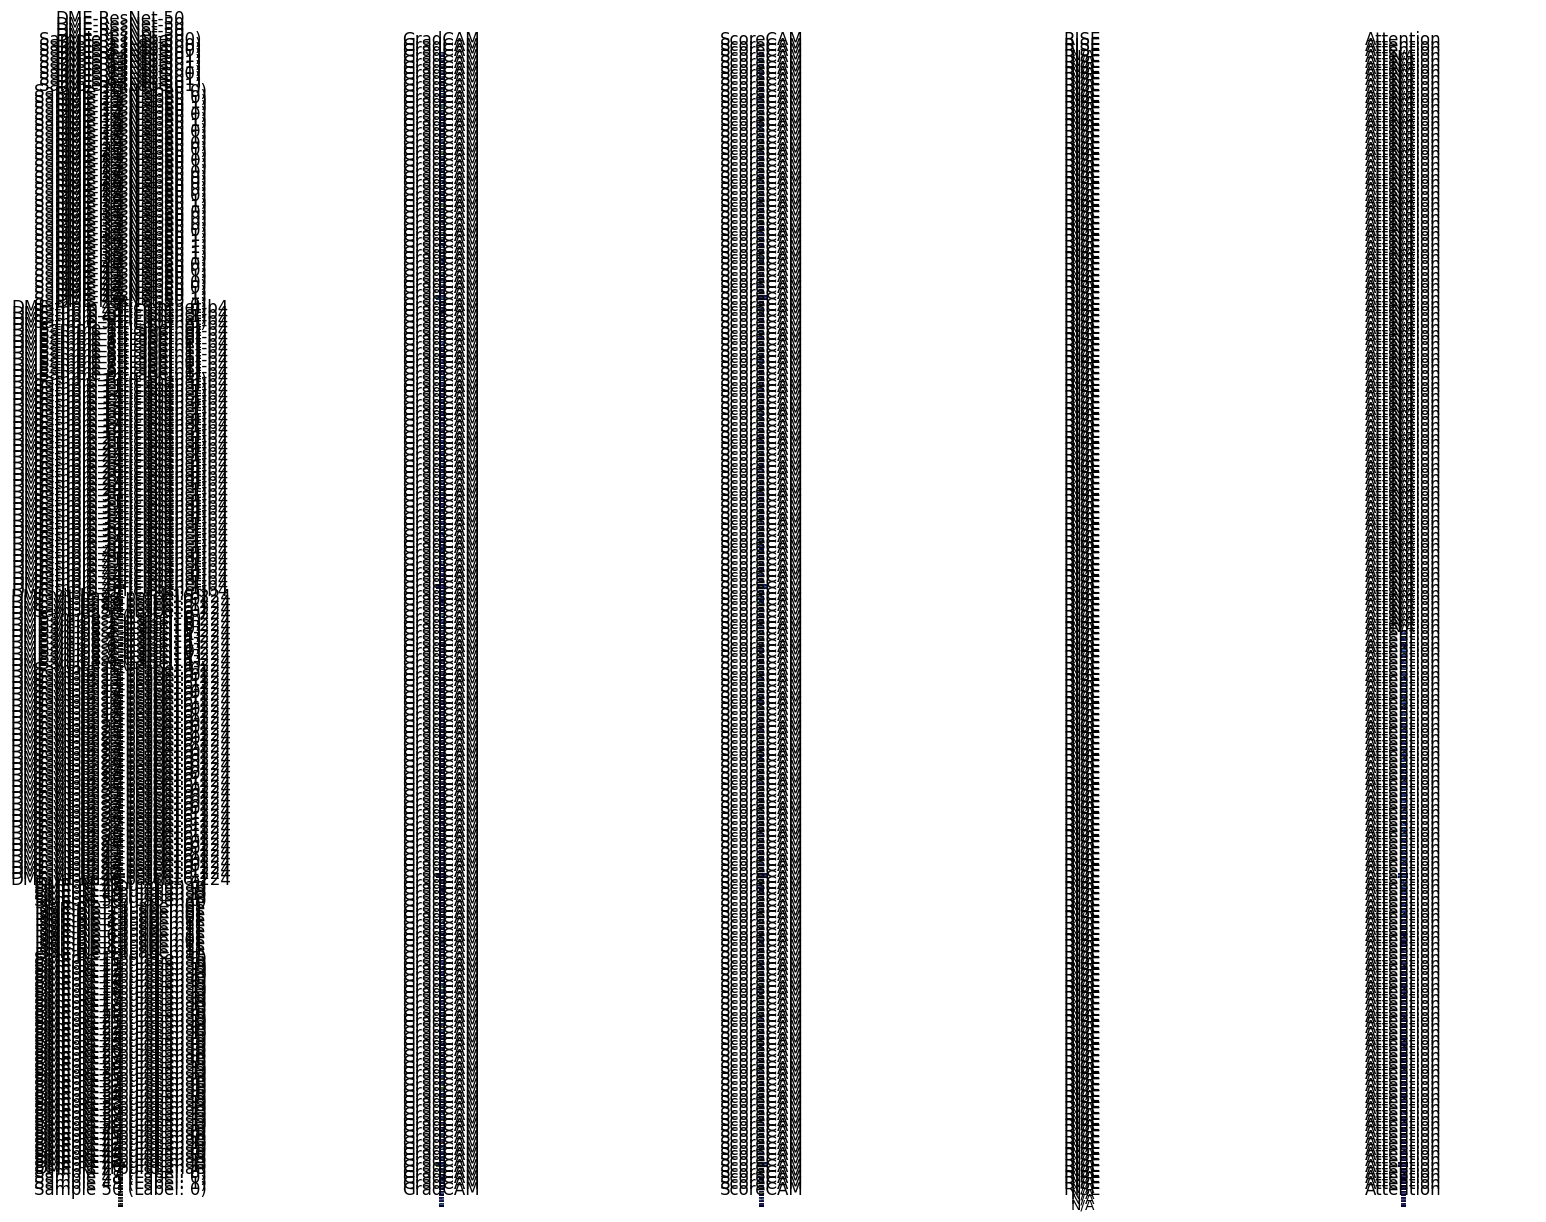

DME visualization saved to: heatmap_results/DME_heatmap_grid.png

=== Heatmap Generation Complete ===
All results saved in: heatmap_results
Generated files:
  - comprehensive_heatmap_grid.png
  - DME_heatmap_grid.png


In [ ]:
# Create individual task-specific visualizations
def create_task_specific_grids(results_dict, output_dir):
    """Create separate visualizations for each task"""
    
    for task in results_dict.keys():
        print(f"Creating visualization for {task}...")
        
        # Create task-specific results dict
        task_results = {task: results_dict[task]}
        
        # Create visualization
        task_grid_path = output_dir / task / "heatmap_grid.png"
        fig = create_heatmap_grid(task_results, task, save_path=task_grid_path)
        
        plt.close(fig)  # Close to save memory
        print(f"{task} visualization saved to: {task_grid_path}")

# Generate task-specific grids
output_dir = Path("./heatmap_results") 
create_task_specific_grids(heatmap_results_v2, output_dir)
